In [1]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt

In [2]:
########################################### Funktionen ############################################################################################

def kinetic (circuit, phi):     # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden

    for i in range(n):
        circuit.p(-phi*2**(i+1),i+1)
        for j in range(i+1,n):
            circuit.cx(j+1,0)
            circuit.cx(i+1,0)
            circuit.p(-phi*2**(i+j+1),0)
            circuit.cx(i+1,0)
            circuit.cx(j+1,0)

    return circuit

def timeEv (circuit, q, phi, iterations):      # Zeitentwicklung
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])

    return circuit

def gaussian (mu, sigma, p, x):     # gibt eine normierte Gaussverteilung mit den entsprechenden Parametern zurück
    psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2))) * np.exp(p*x)
    psi/= np.sqrt(np.sum(np.abs(psi**2)))
    return psi

In [13]:
########################################### Startparameter ########################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

phi = 0.005
phi = phi/4     # Phasenfaktor

# Ortsraumgitter
x_min = -3
x_max = 3
x = np.linspace(x_min, x_max, num=N)

# Zwei Gaußsche Wellenpakete als Anfangszustand
psi1 = gaussian(-1.5, 0.3, -120j, x)     
psi2 = gaussian(1.5, 0.3, 120j, x) 


normf = sum((abs(psi1+psi2))**2)     # Normierungsfaktor sqrt(2) damit beide Gauß-Kurven eine Wahrscheinlichkeit von 0.5 haben, Genauigkeit der Variablen reicht hier nicht aus, daher wird der Normierungsfaktor von Hand berechnet
psi1 /= np.sqrt(normf)
psi2 /= np.sqrt(normf)

#plt.plot(x, psi1+psi2)

In [14]:
########################################### Simulation Zustandsvektor ############################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
circuit = QuantumCircuit(q)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize((psi1 + psi2),q[1:])

simulator = Aer.get_backend('statevector_simulator')    # Festlegen des Simulators, hier Zustandsvektor-Simulator

prob_ev = []    # Array, in dem die Zeitentwicklung der Wahrscheinlichkeitsdichte gespeichert wird

# Speichern des Anfangszustandsvektors 
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
prob = statevector.probabilities()
prob = prob[::2]
prob_ev.append(prob)

# Simulation der Zustandsvektoren der einzelnen Zeitschritte 
it = 5
rg = 6      # Anzahl der Zeitzwischenschritte die geplottet werden sollen

for i in range(rg):
    timeEv(circuit=circuit, q=q, phi=phi, iterations=it)
    prob = []
    statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
    print(str(i) + ':' + str(statevector.is_valid()))           # Überprüfung ob Zustandsvektor normiert ist, Ausgabe um Fortschritt der Simulation zu verfolgen
    prob = statevector.probabilities()
    prob = prob[::2]
    prob_ev.append(prob)

0:True
1:True
2:True
3:True
4:True
5:True


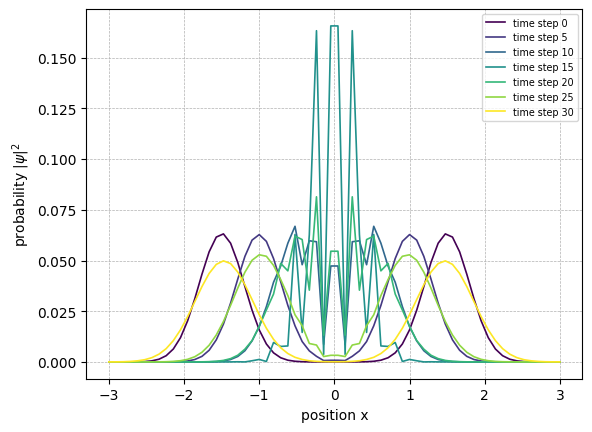

In [16]:
########################################### Plots ################################################################################################

peak_position = []      # Array, in dem die Positionen der Gauß-Kurven gespeichert werden
leg = []    # Array für die Legende

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

for i in range(len(prob_ev)):
    plt.plot(x, prob_ev[i], color=colors[i], linewidth=1.2)
    peak_position.append(x[np.argmax(prob_ev[i])])
    leg.append("time step " + str(i*it))

plt.xlabel('position x')
plt.ylabel(r'probability $|\psi|^2$')
plt.legend(leg, loc='upper right', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_interferenz.jpg', bbox_inches='tight', dpi=300)